<a href="https://colab.research.google.com/github/ahmedfathy17/3D-Voronoi-Diagram-generation-code-using-modified-MPS/blob/master/LHC_Yandex_Contest_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function

import math
import tensorflow as tf
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import make_scorer
import argparse

from tensorflow.python.data import Dataset

import glob
import os
from itertools import repeat
import xgboost
from sklearn.model_selection import train_test_split
import seaborn as sns

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [0]:
folder_path = "/content/drive/My Drive/Muon"
SIMPLE_FEATURE_COLUMNS = ['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]','avg_cs[1]', 'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]', 'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
                          'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]', 'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]', 'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]', 
                          'MatchedHit_Z[1]','MatchedHit_Z[2]', 'MatchedHit_Z[3]', 'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]', 'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
                          'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]', 'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]', 'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
                          'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]', 'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]', 'Lextra_Y[1]', 
                          'Lextra_Y[2]', 'Lextra_Y[3]', 'NShared', 'Mextra_DX2[0]','Mextra_DX2[1]', 'Mextra_DX2[2]', 'Mextra_DX2[3]', 'Mextra_DY2[0]',
                          'Mextra_DY2[1]', 'Mextra_DY2[2]', 'Mextra_DY2[3]', 'FOI_hits_N', 'PT', 'P']


USED_FEATURES= ['ncl[3]', 'ndof', 'MatchedHit_TYPE[0]', 'MatchedHit_TYPE[1]' , 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]', 'MatchedHit_X[2]', 'MatchedHit_Y[2]',
                          'MatchedHit_DX[2]', 'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]', 'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]' ,
                          'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]', 'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]', 
                'MatchedHit_DT[2]', 'NShared']


TRAIN_COLUMNS = ["label", "weight"]

FOI_COLUMNS = ["FOI_hits_X", "FOI_hits_Y", "FOI_hits_T", "FOI_hits_Z", "FOI_hits_DX", "FOI_hits_DY", "FOI_hits_S"]

ID_COLUMN = "id"

N_STATIONS = 4
FEATURES_PER_STATION = 6
N_FOI_FEATURES = N_STATIONS*FEATURES_PER_STATION
# The value to use for stations with missing hits
# when computing FOI features
EMPTY_FILLER = 1000

# Examples on working with the provided files in different ways

# hdf is all fine - but it requires unpickling the numpy arrays
# which is not guranteed

def load_data_csv(path, feature_columns):
    train = pd.concat([
        pd.read_csv(os.path.join(path, "train_part_%i.csv.gz" % i),
                    usecols= [ID_COLUMN] + feature_columns + TRAIN_COLUMNS, index_col=ID_COLUMN)
        for i in (1, 2)], axis=0, ignore_index=True)
    test = pd.read_csv(os.path.join(path, "test_public_v2.csv.gz"),
                       usecols=[ID_COLUMN] + feature_columns, index_col=ID_COLUMN)
    return train, test
  
def load_data_csv_20000(path, feature_columns):
  
    train = pd.read_csv(os.path.join(path, "train_dataset_20000.csv"),usecols= feature_columns + TRAIN_COLUMNS)
       
    test = pd.read_csv(os.path.join(path, "test_dataset_2800.csv"),
                       usecols= feature_columns)
    return  train, test
  
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

def construct_weight_column(input_features):
  
  output_targets = pd.DataFrame()
  
  output_targets["weights"] =  input_features["weight"]
  return output_targets

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  
  output_targets["label"] =  california_housing_dataframe["label"]
  return output_targets

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Convert pandas data into a dict of np arrays.
    #weights = {key:np.array(value) for key,value in dict(weights).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels
  

def max_value(input_column):
    mx = abs(max(input_column))
    mn = abs(min(input_column))
    if mx > mn:
      return mx
    else:
      if mn == 999 :
        return mx
      return mn
    
def draw_hist_2(panda_arrray):
  for i in panda_arrray:
      plt.figure() 
      plt.hist(panda_arrray[i])
      plt.xlabel(i)

  return 0

def linear_scale(series):
    min_val = series.min()
    max_val = series.max()
    scale = (max_val - min_val) / 2.0
    return series.apply(lambda x:((x - min_val) / scale) - 1.0)
  
def normalize_from_0_to_1(series):
    min_val = series.min()
    max_val = series.max()
    return series.apply(lambda x:((x-min_val)/(max_val-min_val)))
  


def select_and_transform_features(source_df):
 
  selected_examples = pd.DataFrame()
  
  
  #Divid ncl[] by max to be in range 1:0
  
  m_value =max_value(source_df['ncl[3]'])
  selected_examples['ncl_3'] = source_df['ncl[3]'].apply(lambda x: x/m_value)
  
 
  
  # ndof > splite into three columns 
  selected_examples['ndof_6'] = source_df['ndof'].apply(lambda l: 1.0 if l == 6 else 0.0)
  selected_examples['ndof_8'] = source_df['ndof'].apply(lambda l: 1.0 if l == 8 else 0.0)
 
  # MatchedHit_TYPE[0] > transform into 0 &1
  selected_examples['MatchedHit_TYPE_0'] = source_df['MatchedHit_TYPE[0]'].apply(lambda l: 1.0 if l == 1.0 else 0.0)   
  # MatchedHit_TYPE[1] > transform into 0 &1
  selected_examples['MatchedHit_TYPE_1'] = source_df['MatchedHit_TYPE[1]'].apply( lambda l: 1.0 if l == 1.0 else 0.0)    
   # MatchedHit_TYPE[2] > splite into three columns 
  selected_examples['MatchedHit_TYPE_2_1'] = source_df['MatchedHit_TYPE[2]'].apply(lambda l: 1.0 if l == 1.0 else 0.0)   
  selected_examples['MatchedHit_TYPE_2_2'] = source_df['MatchedHit_TYPE[2]'].apply(lambda l: 1.0 if l == 2.0 else 0.0)
  selected_examples['MatchedHit_TYPE_2_0'] = source_df['MatchedHit_TYPE[2]'].apply(lambda l: 1.0 if l == 0.0 else 0.0) 
  # MatchedHit_TYPE[3] > splite into three columns 
  selected_examples['MatchedHit_TYPE_3_1'] = source_df['MatchedHit_TYPE[3]'].apply(lambda l: 1.0 if l == 1.0 else 0.0)   
  selected_examples['MatchedHit_TYPE_3_2'] = source_df['MatchedHit_TYPE[3]'].apply(lambda l: 1.0 if l == 2.0 else 0.0)
  selected_examples['MatchedHit_TYPE_3_0'] = source_df['MatchedHit_TYPE[3]'].apply(lambda l: 1.0 if l == 0.0 else 0.0)
  
  #Divid MatchedHit_X[] by max to be in range 1:0
  m_value =max_value(source_df['MatchedHit_X[2]'])  
  selected_examples['MatchedHit_X_2'] = source_df['MatchedHit_X[2]'].apply(lambda x: x/m_value)    
  
  
  m_value =max_value(source_df['MatchedHit_Y[2]'])  
  selected_examples['MatchedHit_Y_2'] = source_df['MatchedHit_Y[2]'].apply(lambda x: x/m_value)    
  
  #Divid MatchedHit_DX[] by max to be in range 1:0
  m_value =max_value(source_df['MatchedHit_DX[2]'])
  selected_examples['MatchedHit_DX_2'] = source_df['MatchedHit_DX[2]'].apply(lambda x: x/m_value)   
  m_value =max_value(source_df['MatchedHit_DX[3]'])  
  selected_examples['MatchedHit_DX_3'] = source_df['MatchedHit_DX[3]'].apply(lambda x: x/m_value)
   
  #Divid MatchedHit_DY[] by max to be in range 1:0
  m_value =max_value(source_df['MatchedHit_DY[0]'])
  selected_examples['MatchedHit_DY_0'] = source_df['MatchedHit_DY[0]'].apply(lambda x: x/m_value)   
  m_value =max_value(source_df['MatchedHit_DY[1]'])  
  selected_examples['MatchedHit_DY_1'] = source_df['MatchedHit_DY[1]'].apply(lambda x: x/m_value)    
  m_value =max_value(source_df['MatchedHit_DY[2]'])
  selected_examples['MatchedHit_DY_2'] = source_df['MatchedHit_DY[2]'].apply(lambda x: x/m_value)   
  m_value =max_value(source_df['MatchedHit_DY[3]'])  
  selected_examples['MatchedHit_DY_3'] = source_df['MatchedHit_DY[3]'].apply(lambda x: x/m_value)
  
  #Divid MatchedHit_DZ[] by max to be in range 1:0
  m_value =max_value(source_df['MatchedHit_DZ[0]'])
  selected_examples['MatchedHit_DZ_0'] = source_df['MatchedHit_DZ[0]'].apply(lambda x: x/m_value)   
  
  m_value =max_value(source_df['MatchedHit_DZ[2]'])
  selected_examples['MatchedHit_DZ_2'] = source_df['MatchedHit_DZ[2]'].apply(lambda x: x/m_value)   
  m_value =max_value(source_df['MatchedHit_DZ[3]'])  
  selected_examples['MatchedHit_DZ_3'] = source_df['MatchedHit_DZ[3]'].apply(lambda x: x/m_value)
  
  #Divid MatchedHit_T[] by max to be in range 1:0
  m_value =max_value(source_df['MatchedHit_T[0]'])
  selected_examples['MatchedHit_T_0'] = source_df['MatchedHit_T[0]'].apply(lambda x: x/m_value)   
  m_value =max_value(source_df['MatchedHit_T[1]'])  
  selected_examples['MatchedHit_T_1'] = source_df['MatchedHit_T[1]'].apply(lambda x: x/m_value)    
  
  #Divid MatchedHit_DT[] by max to be in range 1:0
  m_value =max_value(source_df['MatchedHit_DT[0]'])
  selected_examples['MatchedHit_DT_0'] = source_df['MatchedHit_DT[0]'].apply(lambda x: x/m_value)   
  m_value =max_value(source_df['MatchedHit_DT[1]'])  
  selected_examples['MatchedHit_DT_1'] = source_df['MatchedHit_DT[1]'].apply(lambda x: x/m_value)    
  m_value =max_value(source_df['MatchedHit_DT[2]'])
  selected_examples['MatchedHit_DT_2'] = source_df['MatchedHit_DT[2]'].apply(lambda x: x/m_value) 

  # NShared >splite into 3 columns
  selected_examples['NShared_0'] = source_df['NShared'].apply(lambda l: 1 if l == 0 else 0.0)   
  selected_examples['NShared_1'] = source_df['NShared'].apply(lambda l: 1 if l == 1 else 0.0)
      
  #Divid weight by max to be in range 1:0 
  selected_examples['weight_unnormalized'] =source_df['weight']
  selected_examples['weight'] = normalize_from_0_to_1(source_df['weight'])
  
  
  return selected_examples

In [0]:
#access google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_20000, test_2800= load_data_csv_20000(folder_path, USED_FEATURES)
# splite training data into training part and validation part
train_part, validation_part = train_test_split(train_20000, test_size=0.25, shuffle=True)

# Extract the traing features
training_examples = select_and_transform_features(train_part)
#Extract the traing targets 
training_targets = preprocess_targets(train_part)
#extract training_weights
training_weights = construct_weight_column(train_part)

# Extract the validation features
validation_examples = select_and_transform_features(validation_part)
#Extract the validation targets 
validation_targets = preprocess_targets(validation_part)
#extract validation_weights
validation_weights = construct_weight_column(validation_part)


In [0]:
training_examples['weight_unnormalized'].describe()

count   15000.0
mean        3.6
std        29.8
min     -1250.9
25%         1.4
50%         2.2
75%         2.9
max       934.8
Name: weight_unnormalized, dtype: float64

'\n # Output a graph of loss metrics over periods.\nplt.ylabel("weights")\nplt.xlabel("Periods")\nplt.title("weights vs. Periods")\nplt.plot(weights_0[0:10], label="weights_0")\nplt.plot(weights_1[0:10], label="weights_1")\nplt.legend()\nplt.show()'

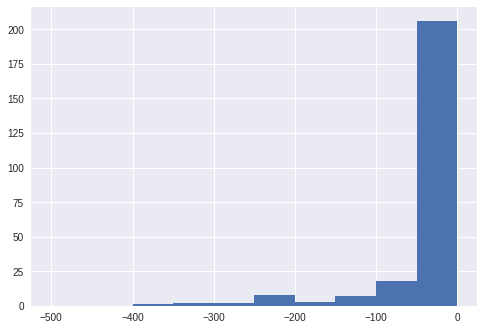

In [0]:
labels_np = np.array(training_targets['label'])
index_0 = np.where(labels_np == 0)[0]
index_1 = np.where(labels_np == 1)[0]

weights_np = np.array(training_examples['weight_unnormalized'])

weights_0 = weights_np[index_0]
weights_1 = weights_np[index_1]

plt.figure() 
plt.hist(weights_0, range = [-500,0])

'''
 # Output a graph of loss metrics over periods.
plt.ylabel("weights")
plt.xlabel("Periods")
plt.title("weights vs. Periods")
plt.plot(weights_0[0:10], label="weights_0")
plt.plot(weights_1[0:10], label="weights_1")
plt.legend()
plt.show()'''


In [0]:
max(weights_1)

4.6760671494247585

In [0]:
def my_model(features, labels, mode, params):
    """DNN with three hidden layers and learning_rate=0.1."""
    # Create three fully connected layers.
    net = tf.feature_column.input_layer(features, params['feature_columns'])
    for units in params['hidden_units']:
        net = tf.layers.dense(net, units=units, activation=tf.nn.relu)

    # Compute logits (1 per class).
    logits = tf.layers.dense(net, params['n_classes'], activation=None)

    # Compute predictions.
    predicted_classes = tf.argmax(logits, 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits),
            'logits': logits,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Compute loss.
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits, weights = features['weight'])

    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   name='acc_op')
    metrics = {'accuracy': accuracy}
    tf.summary.scalar('accuracy', accuracy[1])

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)

    # Create training op.
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = tf.train.AdagradOptimizer(learning_rate=0.01)#*************************************************************
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [0]:
def main(argv):
  #args = parser.parse_args(argv[1:])
  
    # Fetch the data
    train_x = training_examples
    train_y = training_targets
    test_x = validation_examples
    test_y = validation_targets
    batch_size = 25
    hidden_units = [18,9,4]
    n_classes = 2
    steps = 50000
    
    periods = 10
    steps_per_period = steps / periods
    
    # Create input functions.
    training_input_fn = lambda: my_input_fn(train_x, train_y, batch_size = batch_size)
    predict_training_input_fn =  lambda: my_input_fn(train_x, train_y, num_epochs=1,shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(test_x, test_y, num_epochs=1, shuffle=False)

    # Feature columns describe how to use the input.
    my_feature_columns = []
    for key in train_x.keys() :
      if key != "weight":
        my_feature_columns.append(tf.feature_column.numeric_column(key=key))
  
   # Build hidden layer DNN with n, ... units respectively.
    classifier = tf.estimator.Estimator(
        model_fn=my_model,
        params={
            'feature_columns': my_feature_columns,
            # Two hidden layers of 10 nodes each.
            'hidden_units': hidden_units,                         
            # The model must choose between 2 classes.
            'n_classes': n_classes,
        })

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):

      #Train the Model.
      classifier.train( input_fn = training_input_fn, steps= steps_per_period)
      
      #Evaluate the model.
      #eval_result = classifier.evaluate(input_fn = predict_training_input_fn)

     # print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))


      # Take a break and compute probabilities.
      training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
      training_probabilities = np.array([item['probabilities'] for item in training_predictions]) 
      training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions]) 
      training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,2)
      
      # Calculating Scoring 
      scoring = rejection90(np.array(train_y['label']), training_pred_class_id , sample_weight = np.array(train_x['weight_unnormalized']))
      print("scoring (on validation data): %0.2f" % scoring)
      
      validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
      validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])
      validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions]) 
      validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,2)    

      # Compute training and validation errors.
      training_log_loss = metrics.log_loss(train_y, training_pred_one_hot)
      validation_log_loss = metrics.log_loss(test_y, validation_pred_one_hot)
      # Occasionally print the current loss.
      print("  period %02d : %0.2f" % (period, validation_log_loss))
      # Calculating Scoring 
      scoring = rejection90(np.array(test_y['label']), validation_pred_class_id , sample_weight = np.array(test_x['weight_unnormalized']))
      print("scoring (on validation data): %0.2f" % scoring)
      # Add the loss metrics from this period to our list.
      training_errors.append(training_log_loss)
      validation_errors.append(validation_log_loss)
    print("Model training finished.")
    # Remove event files to save disk space.
    
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    # Calculate final predictions (not probabilities, as above).
    final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
    
    # Calculating accuracy
    accuracy = metrics.accuracy_score(test_y, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)
    

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()

    # Output a plot of the confusion matrix.
    cm = metrics.confusion_matrix(validation_targets, final_predictions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class).
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
    # Generate predictions from the model
    '''
    expected = ['Muon', 'Not_Muon']
    

    predictions = classifier.predict( input_fn = predict_training_input_fn)

    for pred_dict, expec in zip(predictions, expected):
        template = ('\nPrediction is "{}" ({:.1f}%), expected "{}"')
        class_id = pred_dict['class_ids'][0]
        probability = pred_dict['probabilities'][class_id]

        print(template.format(expected[class_id],100 * probability, expec))'''


Training model...
LogLoss error (on validation data):
scoring (on validation data): 0.51
  period 00 : 0.93
scoring (on validation data): 0.46
scoring (on validation data): 0.51
  period 01 : 0.88
scoring (on validation data): 0.46
scoring (on validation data): 0.51
  period 02 : 0.88
scoring (on validation data): 0.46
scoring (on validation data): 0.51
  period 03 : 0.86
scoring (on validation data): 0.46
scoring (on validation data): 0.51
  period 04 : 0.87
scoring (on validation data): 0.46
scoring (on validation data): 0.50
  period 05 : 0.86
scoring (on validation data): 0.45
scoring (on validation data): 0.51
  period 06 : 0.87
scoring (on validation data): 0.46
scoring (on validation data): 0.51
  period 07 : 0.86
scoring (on validation data): 0.46
scoring (on validation data): 0.50
  period 08 : 0.87
scoring (on validation data): 0.45
scoring (on validation data): 0.51
  period 09 : 0.84
scoring (on validation data): 0.46
Model training finished.
Final accuracy (on validation d

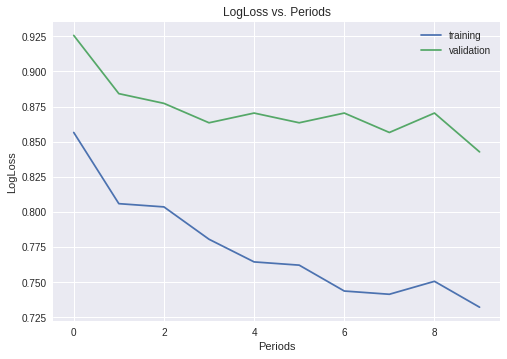

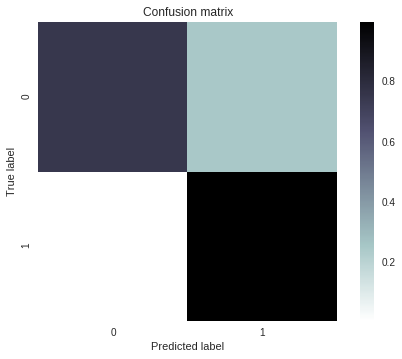

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [0]:
if __name__ == '__main__':
    #tf.logging.set_verbosity(tf.logging.INFO)
    tf.app.run(main)

***Next boxes used for load the full data*** 

In [0]:
train_data = train_data[USED_FEATURES+TRAIN_COLUMNS]
test_data = test_data[USED_FEATURES]

In [0]:
#randomization 
train_data = train_data.reindex(np.random.permutation(train_data.index))
test_data = test_data.reindex(np.random.permutation(test_data.index))

#select amount for traning and testing 
number_raw = 20000
train_data = train_data.head(number_raw)
test_data = test_data.head(int(number_raw * 0.14))

In [0]:
# Save 20000 raws from dataset in csv file in order not load the data in every tim time
train_data.to_csv(os.path.join(folder_path, "train_dataset_20000.csv"), sep=',', encoding='utf-8')
test_data.to_csv(os.path.join(folder_path, "test_dataset_2800.csv"), sep=',', encoding='utf-8')

In [0]:
# load data from google drive
train_data, test_data = load_data_csv(folder_path, SIMPLE_FEATURE_COLUMNS)


API >use weight as a feature > bad 

In [0]:
def train_nn_classification_model(my_optimizer, steps, batch_size, hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):


  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  
  classifier = tf.estimator.DNNClassifier(
      feature_columns=construct_feature_columns(training_examples),
      #weight_column = tf.feature_column.numeric_column("weight", shape=(1,), default_value=None,dtype=tf.float32, normalizer_fn=None ),
      weight_column = 'weight',
      n_classes=2,
      hidden_units=hidden_units,
      optimizer=my_optimizer,
      config=tf.contrib.learn.RunConfig(keep_checkpoint_max=1)
  )
  
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["label"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["label"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["label"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  scoring_training = []
  scoring_validation = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
     # Take a break and compute probabilities.
    training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
    training_probabilities = np.array([item['probabilities'] for item in training_predictions]) 
    training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions]) 
    training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,2)
             
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
    validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])
    validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions]) 
    validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,2)    
    
    # Compute training and validation errors.
    training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
    validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_errors.append(training_log_loss)
    validation_errors.append(validation_log_loss)
  print("Model training finished.")
  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.legend()
  plt.show()
  
  # Output a plot of the confusion matrix.
  cm = metrics.confusion_matrix(validation_targets, final_predictions)
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

  return classifier

In [0]:
classifier = train_nn_classification_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0005),
    steps=50,
    batch_size=25,
    hidden_units=[20,10],
    training_examples=t`raining_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [0]:
#scoring "given code from the competition to score your output"

def find_threshold_for_efficiency(a, e, w):
    if e < 0 or e > 1:
        raise ValueError("Efficiency e must be in [0, 1]")
    # Decreasing order
    idx = np.argsort(a)[::-1]
    a_sort = a[idx]
    if w is None:
        w = np.ones(a.shape)
    w_sort = w[idx]
    ecdf = np.cumsum(w_sort)
    if (ecdf[-1]) <= 0:
        raise ValueError("Total weight is < 0")

    target_weight_above_threshold = e * ecdf[-1]
    enough_passing = ecdf >= target_weight_above_threshold
    first_suitable = np.argmax(enough_passing)
    last_unsuitable_inv = np.argmin(enough_passing[::-1])
    if last_unsuitable_inv == 0:
        raise ValueError("Bug in code")
    last_unsuitable_plus = len(a) - last_unsuitable_inv
    return 0.5*(a_sort[first_suitable] + a_sort[last_unsuitable_plus])


def get_rejection_at_efficiency_raw(
        labels, predictions, weights, quantile):
    #signal_mask = (labels >= 1)
    
    signal_mask = np.where(labels >= 1)[0]
    background_mask = ~signal_mask
    if weights is None:
        signal_weights = None
    else:
        signal_weights = weights[signal_mask]
    threshold = find_threshold_for_efficiency(predictions[signal_mask], 
                                              quantile, signal_weights)
    rejected_indices = (predictions[background_mask] < threshold)
    if weights is not None:
        rejected_background = weights[background_mask][rejected_indices].sum()
        weights_sum = np.sum(weights[background_mask])
    else:
        rejected_background = rejected_indices.sum()
        weights_sum = np.sum(background_mask)
    return rejected_background, weights_sum         


def get_rejection_at_efficiency(labels, predictions, threshold, sample_weight=None):
    rejected_background, weights_sum = get_rejection_at_efficiency_raw(
        labels, predictions, sample_weight, threshold)
    return rejected_background / weights_sum


def rejection90(labels, predictions, sample_weight=None):
    return get_rejection_at_efficiency(labels, predictions, 0.9, sample_weight=sample_weight)
# End of scoring "given code from the competition to score your output"
  